In [8]:
import numpy as np
np.random.seed(123)

from util import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def fienup_phase_retrieval(mag, mask=None, beta=0.8, 
                           steps=200, mode='hybrid', verbose=True):
    """
    Implementation of Fienup's phase-retrieval methods. This function
    implements the input-output, the output-output and the hybrid method.
    
    Note: Mode 'output-output' and beta=1 results in 
    the Gerchberg-Saxton algorithm.
    
    Parameters:
        mag: Measured magnitudes of Fourier transform
        mask: Binary array indicating where the image should be
              if padding is known
        beta: Positive step size
        steps: Number of iterations
        mode: Which algorithm to use
              (can be 'input-output', 'output-output' or 'hybrid')
        verbose: If True, progress is shown
    
    Returns:
        x: Reconstructed image
    
    Author: Tobias Uelwer
    Date: 30.12.2018
    
    References:
    [1] E. Osherovich, Numerical methods for phase retrieval, 2012,
        https://arxiv.org/abs/1203.4756
    [2] J. R. Fienup, Phase retrieval algorithms: a comparison, 1982,
        https://www.osapublishing.org/ao/abstract.cfm?uri=ao-21-15-2758
    [3] https://github.com/cwg45/Image-Reconstruction
    """
    
    assert beta > 0, 'step size must be a positive number'
    assert steps > 0, 'steps must be a positive number'
    assert mode == 'input-output' or mode == 'output-output'\
        or mode == 'hybrid',\
    'mode must be \'input-output\', \'output-output\' or \'hybrid\''
    
    if mask is None:
        mask = np.ones(mag.shape)
        
    assert mag.shape == mask.shape, 'mask and mag must have same shape'
    
    # sample random phase and initialize image x 
    y_hat = mag*np.exp(1j*2*np.pi*np.random.rand(*mag.shape))
    x = np.zeros(mag.shape)
    
    # previous iterate
    x_p = None
        
    # main loop
    for i in range(1, steps+1):
        # show progress
        if i % 100 == 0 and verbose: 
            print("step", i, "of", steps)
        
        # inverse fourier transform
        y = np.real(np.fft.ifft2(y_hat))
        
        # previous iterate
        if x_p is None:
            x_p = y
        else:
            x_p = x 
        
        # updates for elements that satisfy object domain constraints
        if mode == "output-output" or mode == "hybrid":
            x = y
            
        # find elements that violate object domain constraints 
        # or are not masked
        indices = np.logical_or(np.logical_and(y<0, mask), 
                                np.logical_not(mask))
        
        # updates for elements that violate object domain constraints
        if mode == "hybrid" or mode == "input-output":
            x[indices] = x_p[indices]-beta*y[indices] 
        elif mode == "output-output":
            x[indices] = y[indices]-beta*y[indices] 
        
        # fourier transform
        x_hat = np.fft.fft2(x)
        
        # satisfy fourier domain constraints
        # (replace magnitude with input magnitude)
        y_hat = mag*np.exp(1j*np.angle(x_hat))
    return x

In [3]:
import sys
sys.path.append('..')

In [10]:
def poisson_noise(magn, alpha=1):
    intens = magn ** 2
    alpha_2 = alpha ** 2
    lmd = intens / alpha_2
    intens_noise = alpha_2 * np.random.poisson(lmd, magn.shape)
    magn_noise = np.sqrt(intens_noise)
    return magn_noise, intens_noise

In [27]:
from data import load
test_data = load(name='MNIST', path='../data/mnist/', batch_size=1024)[0]['test']
batch = next(iter(test_data)).numpy()

In [ ]:
alphas = [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 25.0, 50.0]

for alpha in alphas:
    results = np.zeros_like(batch)
    for i, image in enumerate(batch):
        if i % 100==0:
            print(i)
        magnitudes, _ = poisson_noise(np.abs(np.fft.fft2(image)), alpha=alpha)
        res = []
        errors = []
        for _ in range(3):
            res.append(fienup_phase_retrieval(magnitudes, steps=1000, verbose=False))
            errors.append(np.mean((np.abs(np.fft.fft2(res[-1]))-magnitudes)**2))     
        results[i] = res[np.argmin(errors)]
        
        import pickle
    pickle.dump(batch, open("/home/shared/phase-retrieval/test/HIO_MNIST/original_alpha{}.p".format(alpha), "wb"))
    pickle.dump(results, open("/home/shared/phase-retrieval/test/HIO_MNIST/predicted_noise_alpha{}.p".format(alpha), "wb"))

0
100
200
300
400
500
600
700


In [6]:
### CACHE RESULTS ###

import pickle
pickle.dump(batch, open("/home/shared/phase-retrieval/test/HIO_MNIST/original_alpha{}.p".format(alpha), "wb"))
pickle.dump(results, open("/home/shared/phase-retrieval/test/HIO_MNIST/predicted_noise_alpha{}.p".format(alpha), "wb"))

In [81]:
### LOAD RESULTS ###
import pickle

alpha = 50.0

batch = pickle.load(open("/home/shared/phase-retrieval/test/HIO_MNIST/original_alpha{}.p".format(alpha), "rb"))
results = pickle.load(open("/home/shared/phase-retrieval/test/HIO_MNIST/predicted_noise_alpha{}.p".format(alpha), "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


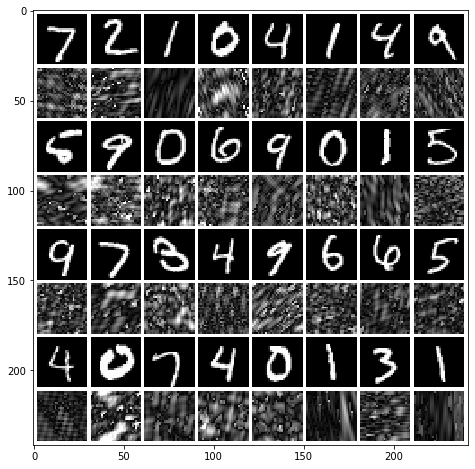

In [82]:
from util import plot_grid

to_plot = np.stack([batch[:32, 0].reshape(4, 8, 28, 28), 
                    results[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
 
                
plot_grid(to_plot, figsize=(8,8), file="../out/hio/MNIST_HIO_alpha{}.png".format(alpha))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


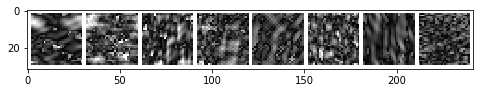

In [83]:
plot_grid(results[8:16, 0].reshape(-1, 1, 28, 28), figsize=(8,8), file="../out/hio/MNIST_HIO_small_alpha{}.png".format(alpha))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


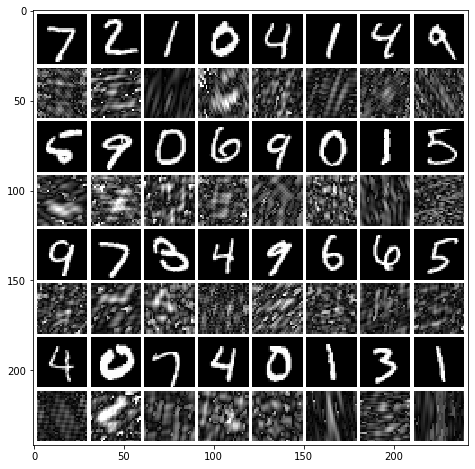

In [84]:
from util import register_croco

results_reg = register_croco(results, batch)

to_plot = np.stack([batch[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
 
                
plot_grid(to_plot, figsize=(8,8), file="../out/hio/MNIST_HIO_reg_alpha{}.png".format(alpha))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


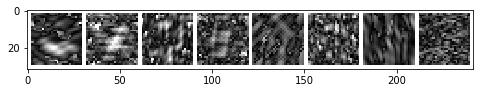

In [85]:
plot_grid(results_reg[8:16, 0].reshape(-1, 1, 28, 28), figsize=(8,8), file="../out/hio/MNIST_HIO_small_reg_alpha{}.png".format(alpha))

In [86]:
from util import benchmark
benchmark(results, batch, check_all=True)

Signal error:
  MSE: 0.1466703763071564, std: 0.05242554072068721
  MAE: 0.3014520042852382, std: 0.06127302134488364
  SSIM: 0.01579611798542444, std: 0.05354915644736076
  Sharpness: 0.27854752915248004, std: 0.056710206377789965
  PhCo-MSE: 0.13847274693398504, std: 0.05076559904037263
  PhCo-MAE: 0.29330987526191166, std: 0.05933672188961063
  PhCo-SSIM: 0.06690360840377294, std: 0.05717356481547152
  CroCo-MSE: 0.1056288966210559, std: 0.03155009589853226
  CroCo-MAE: 0.257304275612114, std: 0.04416338826645556
  CroCo-SSIM: 0.1881453623758222, std: 0.05971187146940538

Magnitude error:
  MSE Magnitude: 47.11925717914539, std: 12.796623483635413

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 3.53] - should be in [0, 1]

Markdown table values:
 0.1467 | 0.3015 | 0.01580 | 0.2785 | 0.1385 | 0.2933 | 0.06690 | 0.1056 | 0.2573 | 0.1881 | 47.12 |


## HIO MNIST


| alpha | MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 0.01 | 0.1703 | 0.2249 | 0.08594 | 0.1518 | 0.05434 | 0.1112 | 0.5292 | 0.04355 | 0.1010 | 0.5726 | 1.367 |
| 0.03 | 0.1703 | 0.2253 | 0.08651 | 0.1550 | 0.05602 | 0.1142 | 0.5166 | 0.04526 | 0.1039 | 0.5590 | 1.424 |
| 0.1 | 0.1702 | 0.2247 | 0.08638 | 0.1530 | 0.05443 | 0.1121 | 0.5251 | 0.04407 | 0.1022 | 0.5659 | 1.400 |
| 0.3 | 0.1690 | 0.2245 | 0.08449 | 0.1533 | 0.05539 | 0.1132 | 0.5154 | 0.04407 | 0.1028 | 0.5586 | 1.399 |
| 1.0 | 0.1693 | 0.2294 | 0.05321 | 0.1633 | 0.05620 | 0.1202 | 0.4605 | 0.04564 | 0.1103 | 0.5009 | 1.811 |
| 3.0 | 0.1654 | 0.2412 | 0.02932 | 0.1902 | 0.06215 | 0.1432 | 0.3843 | 0.04986 | 0.1319 | 0.4276 | 4.313 |
| 10.0 | 0.1595 | 0.2695 | 0.01954 | 0.2417 | 0.09347 | 0.2069 | 0.2503 | 0.06452 | 0.1792 | 0.3478 | 15.37 |
| 25.0 | 0.1536 | 0.2957 | 0.01549 | 0.2751 | 0.1387 | 0.2807 | 0.09061 | 0.08879 | 0.2298 | 0.2560 | 33.84 |
| 50.0 | 0.1467 | 0.3015 | 0.01580 | 0.2785 | 0.1385 | 0.2933 | 0.06690 | 0.1056 | 0.2573 | 0.1881 | 47.12 |

In [ ]:
test_data = load(name='Fashion', path='../data/fashion/', batch_size=1024)[0]['test']
batch = next(iter(test_data)).numpy()

In [ ]:
alphas = [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 25.0, 50.0]

for alpha in alphas:
    results = np.zeros_like(batch)
    for i, image in enumerate(batch):
        if i % 100==0:
            print(i)
        magnitudes, _ = poisson_noise(np.abs(np.fft.fft2(image)), alpha=alpha)
        res = []
        errors = []
        for _ in range(3):
            res.append(fienup_phase_retrieval(magnitudes, steps=1000, verbose=False))
            errors.append(np.mean((np.abs(np.fft.fft2(res[-1]))-magnitudes)**2))     
        results[i] = res[np.argmin(errors)]
        
        import pickle
    pickle.dump(batch, open("/home/shared/phase-retrieval/test/HIO_Fashion/original_alpha{}.p".format(alpha), "wb"))
    pickle.dump(results, open("/home/shared/phase-retrieval/test/HIO_Fashion/predicted_noise_alpha{}.p".format(alpha), "wb"))

In [14]:
### CACHE RESULTS ###

import pickle
pickle.dump(batch, open("/home/shared/phase-retrieval/test/HIO_Fashion/original_alpha{}.p".format(alpha), "wb"))
pickle.dump(results, open("/home/shared/phase-retrieval/test/HIO_Fashion/predicted_noise_alpha{}.p".format(alpha), "wb"))

In [137]:
### LOAD RESULTS ###
import pickle

alpha = 50.0

batch = pickle.load(open("/home/shared/phase-retrieval/test/HIO_Fashion/original_alpha{}.p".format(alpha), "rb"))
results_fashion = pickle.load(open("/home/shared/phase-retrieval/test/HIO_Fashion/predicted_noise_alpha{}.p".format(alpha), "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


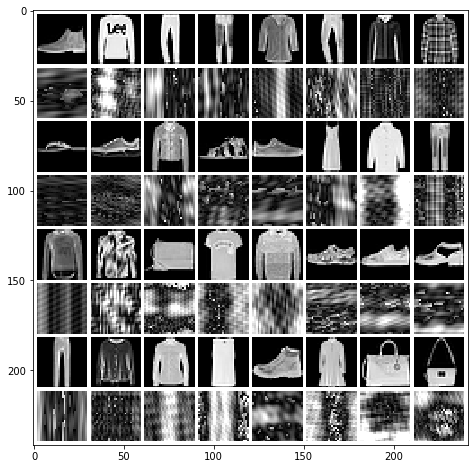

In [138]:
to_plot = np.stack([batch[:32, 0].reshape(4, 8, 28, 28), 
                    results_fashion[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)

plot_grid(to_plot, figsize=(8,8), file="../out/hio/Fashion_HIO_alpha{}.png".format(alpha))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


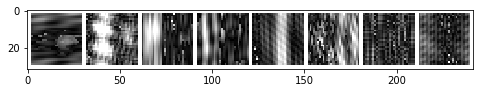

In [139]:
plot_grid(results_fashion[0:8, 0].reshape(-1, 1, 28, 28), figsize=(8,8), file="../out/hio/Fashion_HIO_small_alpha{}.png".format(alpha))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


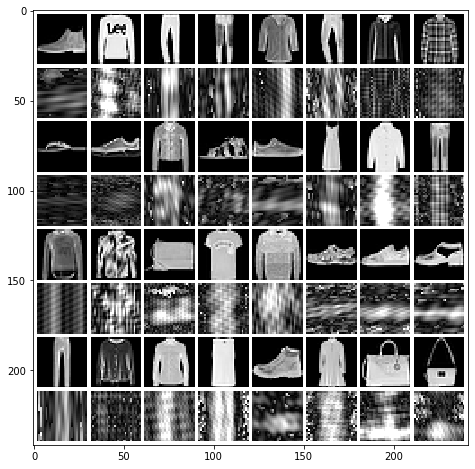

In [140]:
results_reg = register_croco(results_fashion, batch)

to_plot = np.stack([batch[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
 
                
plot_grid(to_plot, figsize=(8,8), file="../out/hio/Fashion_HIO_reg_alpha{}.png".format(alpha))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


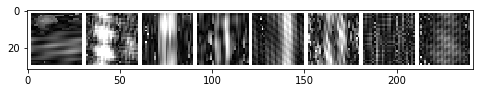

In [141]:
plot_grid(results_reg[0:8, 0].reshape(-1, 1, 28, 28), figsize=(8,8), file="../out/hio/Fashion_HIO_small_reg_alpha{}.png".format(alpha))

In [142]:
benchmark(results_fashion, batch, check_all=True)

Signal error:
  MSE: 0.18901561325583316, std: 0.11114936581441728
  MAE: 0.3452417439693818, std: 0.11750060563552753
  SSIM: 0.03684747050409626, std: 0.10406093805688889
  Sharpness: 0.25855961825655627, std: 0.06094340707619914
  PhCo-MSE: 0.19929616970057396, std: 0.10876850655599715
  PhCo-MAE: 0.35956397869449575, std: 0.11521643062769078
  PhCo-SSIM: 0.05017943638338962, std: 0.09343445600736584
  CroCo-MSE: 0.08679476250472362, std: 0.03803608453871402
  CroCo-MAE: 0.22568343723833095, std: 0.05308684599078958
  CroCo-SSIM: 0.2779919815395936, std: 0.08550911515584968

Magnitude error:
  MSE Magnitude: 31.849443718487468, std: 14.086016956486286

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 3.65] - should be in [0, 1]

Markdown table values:
 0.1890 | 0.3452 | 0.03685 | 0.2586 | 0.1993 | 0.3596 | 0.05018 | 0.08679 | 0.2257 | 0.2780 | 31.85 |


## HIO Fashion


| alpha | MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 0.01 | 0.2161 | 0.3346 | 0.06474 | 0.2180 | 0.1214 | 0.2252 | 0.3109 | 0.06517 | 0.1611 | 0.4362 | 0.02893 |
| 0.03 | 0.2218 | 0.3394 | 0.06139 | 0.2176 | 0.1256 | 0.2293 | 0.3094 | 0.06520 | 0.1615 | 0.4376 | 0.02810 |
| 0.1 | 0.2216 | 0.3385 | 0.06026 | 0.2176 | 0.1226 | 0.2266 | 0.3100 | 0.06505 | 0.1610 | 0.4373 | 0.02890 |
| 0.3 | 0.2195 | 0.3385 | 0.05775 | 0.2183 | 0.1221 | 0.2256 | 0.3097 | 0.06398 | 0.1603 | 0.4351 | 0.04849 |
| 1.0 | 0.2146 | 0.3339 | 0.05305 | 0.2210 | 0.1235 | 0.2303 | 0.2856 | 0.06506 | 0.1639 | 0.4079 | 0.2425 |
| 3.0 | 0.2133 | 0.3383 | 0.03619 | 0.2257 | 0.1199 | 0.2335 | 0.2559 | 0.06454 | 0.1701 | 0.3762 | 1.691 |
| 10.0 | 0.2054 | 0.3433 | 0.03233 | 0.2375 | 0.1810 | 0.3185 | 0.1088 | 0.06724 | 0.1874 | 0.3472 | 8.524 |
| 25.0 | 0.1968 | 0.3456 | 0.03593 | 0.2520 | 0.2068 | 0.3600 | 0.04720 | 0.07550 | 0.2078 | 0.3109 | 19.42 |
| 50.0 | 0.1890 | 0.3452 | 0.03685 | 0.2586 | 0.1993 | 0.3596 | 0.05018 | 0.08679 | 0.2257 | 0.2780 | 31.85 |
